# Library


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist  # 라이브러리가 기본으로 제공하는 mnist 데이터셋
from tensorflow.keras.utils import to_categorical  # one-hot encoding 을 위한 함수
from tensorflow.keras.models import Sequential  # 레이어를 층층히 쌓아가는 연쇄 모델
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model  

# Data load

[shape] train: (50000, 28, 28) 
[shape] test: (10000, 28, 28) 
[shape] valid: (10000, 28, 28) 


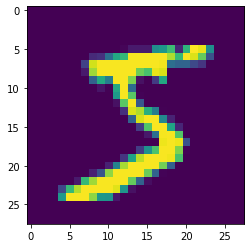

In [36]:
(x_train_, y_train_), (x_valid_, y_valid_) = mnist.load_data()
x_test_, y_test_ = x_train_[50000:], y_train_[50000:]
x_train_,y_train_ = x_train_[:50000], y_train_[:50000]

print(f'[shape] train: {x_train_.shape} ')
print(f'[shape] test: {x_test_.shape} ')
print(f'[shape] valid: {x_valid_.shape} ')

plt.imshow(x_train_[0])

In [ ]:
## preprocessing

In [37]:
input_shape = x_train_.shape[1]*x_train_.shape[2]
class_num = len(set(y_train_))

x_train = (x_train_/255.0).reshape(-1, input_shape)
x_test = (x_test_/255.0).reshape(-1, input_shape)
x_valid = (x_valid_/255.0).reshape(-1, input_shape)

print(f'[shape] before train: {x_train_.shape} ')
print(f'[shape] after train: {x_train.shape} ')


[shape] before train: (50000, 28, 28) 
[shape] after train: (50000, 784) 


In [38]:
# one-hot encoding
I = np.eye(10)

y_train = I[y_train_]
y_test = I[y_test_]
y_valid = I[y_valid_]

print(f'[example] before train: {y_train_[1]} ')
print(f'[example] after train: {y_train[1]} ')


[example] before train: 0 
[example] after train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 


In [19]:
dataloader = MNISTLoader()
		
x_train, y_train = dataloader.train
x_validation, y_validation = dataloader.validation

# base Model

In [39]:
# -------------------------
# Feed-forward network
# -------------------------
class Network:
    def __init__(self,layers):
        self.layers = layers
    
    def forward(self,Z):
        for l in self.layers: Z = l.forward(Z)
        return Z
    
    def gradprop(self,DZ):
        for l in self.layers[::-1]: DZ = l.gradprop(DZ)
        return DZ
    
    def relprop(self, R):
        for I in self.layers[::-1]: R = I.relprop(R)
        return R

# -------------------------
# ReLU activation layer
# -------------------------
class ReLU:
    def forward(self,X):
        self.Z = X>0
        return X*self.Z
    
    def gradprop(self,DY):
        return DY*self.Z
    
    def relprop(self, R): 
        return R
    
# -------------------------
# Fully-connected layer
# -------------------------
class Linear:

    def __init__(self, weight, bias):
        self.W = weight
        self.B = bias

    def forward(self,X):
        self.X = X
        return np.dot(self.X,self.W)+self.B

    def gradprop(self,DY):
        self.DY = DY # DY는 target을 넣으면 됨. Desired Y
        return np.dot(self.DY,self.W.T)

class NextLinear(Linear): # implementing Z+ rule
    def relprop(self,R):
        V = np.maximum(0,self.W) # V는 W_ij^+를 의미함.
        Z = np.dot(self.X,V)+1e-9; S = R/Z
        C = np.dot(S,V.T);         R = self.X*C
        return R
    
class FirstLinear(Linear): # implementing Zbeta rule
    def relprop(self,R):
        W,V,U = self.W,np.maximum(0,self.W),np.minimum(0,self.W)
#        X,L,H = self.X,self.X*0+utils.lowest,self.X*0+utils.highest
        X,L,H = self.X,self.X*0+(-1),self.X*0+(1.0)


        Z = np.dot(X,W)-np.dot(L,V)-np.dot(H,U)+1e-9; S = R/Z
        R = X*np.dot(S,W.T)-L*np.dot(S,V.T)-H*np.dot(S,U.T)
        return R

## 참고용

In [3]:
# -------------------------
# Feed-forward network
# -------------------------
class Network:
    def __init__(self,layers):
        self.layers = layers
    
    def forward(self,Z):
        for l in self.layers: Z = l.forward(Z)
        return Z
    
    def gradprop(self,DZ):
        for l in self.layers[::-1]: DZ = l.gradprop(DZ)
        return DZ
    
    def relprop(self, R):
        for I in self.layers[::-1]: R = I.relprop(R)
        return R

# -------------------------
# ReLU activation layer
# -------------------------
class ReLU:
    def forward(self,X):
        self.Z = X>0
        return X*self.Z
    
    def gradprop(self,DY):
        return DY*self.Z
    
    def relprop(self, R): 
        return R
    
# -------------------------
# Fully-connected layer
# -------------------------
class Linear:

  def __init__(self, weight, bias):
    self.W = weight
    self.B = bias

  def forward(self,X):
    self.X = X
    return np.dot(self.X,self.W)+self.B

  def gradprop(self,DY):
    self.DY = DY # DY는 target을 넣으면 됨. Desired Y
    return np.dot(self.DY,self.W.T)


class NextLinear(Linear): # implementing Z+ rule
    def relprop(self,R):
        V = np.maximum(0,self.W) # V는 W_ij^+를 의미함.
        Z = np.dot(self.X,V)+1e-9; S = R/Z
        C = np.dot(S,V.T);         R = self.X*C
        return R
    
class FirstLinear(Linear): # implementing Zbeta rule
    def relprop(self,R):
        W,V,U = self.W,np.maximum(0,self.W),np.minimum(0,self.W)
#        X,L,H = self.X,self.X*0+utils.lowest,self.X*0+utils.highest
        X,L,H = self.X,self.X*0+(-1),self.X*0+(1.0)


        Z = np.dot(X,W)-np.dot(L,V)-np.dot(H,U)+1e-9; S = R/Z
        R = X*np.dot(S,W.T)-L*np.dot(S,V.T)-H*np.dot(S,U.T)
        return R

# Network 구조 입력
nn = Network([
    FirstLinear(final_W1, final_b1),ReLU(),
    NextLinear(final_W2, final_b2),ReLU(),
    NextLinear(final_W3, final_b3),ReLU(),
    NextLinear(final_W4, final_b4),ReLU(),
    NextLinear(final_Wh, final_bh),ReLU(),
])

rand_num = np.random.permutation(n_total)

X = total_x[rand_num,:] # Input
T = total_y[rand_num,:] # Target
Y = nn.forward(X) # Output
S = nn.gradprop(T)**2
Y = nn.forward(X)

D = nn.relprop(Y*T)

NameError: name 'final_W1' is not defined